In [21]:
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Setting library defaults

In [13]:
# code settings
pd.set_option('display.max_columns', None)

# visualization settings
plt.rc('figure', figsize=(9,9))
sns.set_style('darkgrid')

## Importing the Data

In [16]:
supp_county = pd.read_csv('../data/processed/supp_county.csv')

supp_county.head(5)

,FIPS,State,County,2010 Census Population,"Population Estimate, 2011","Population Estimate, 2012","Population Estimate, 2013","Population Estimate, 2014","Population Estimate, 2015","Population Estimate, 2016"
0,1001.0,Alabama,Autauga,"54,571","55,255","55,027","54,792","54,977","55,035","55,416"
1,1003.0,Alabama,Baldwin,"182,265","186,653","190,403","195,147","199,745","203,690","208,563"
2,1005.0,Alabama,Barbour,"27,457","27,326","27,132","26,938","26,763","26,270","25,965"
3,1007.0,Alabama,Bibb,"22,915","22,736","22,645","22,501","22,511","22,561","22,643"
4,1009.0,Alabama,Blount,"57,322","57,707","57,772","57,746","57,621","57,676","57,704"


A closer look at the most recent (2016) estimated population data for each county plotted against the 2010 census data. Most of the counties have fall along a line, which looks approximately like a slope of 1, meaning that the population change was minimal. Points outside of this pseudo-regression are counties whose population changed over the 6 year span. Points above the line are counties where population increased and points below the line are a decrease in population.   

([], <a list of 0 Text yticklabel objects>)

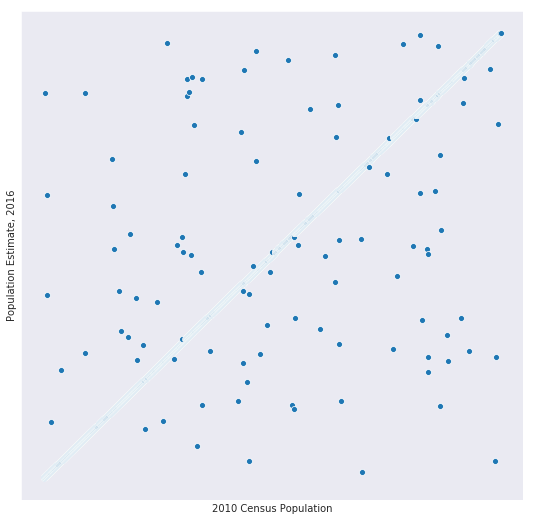

In [23]:
sns.scatterplot(x = '2010 Census Population', 
                y = 'Population Estimate, 2016',
                data = supp_county)

plt.xticks([])
plt.yticks([])

Types of plots

correlation plots for all datasets
